In [ ]:
!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8MB 25kB/s 
     |████████████████████████████████| 3.9MB 33.1MB/s 
     |████████████████████████████████| 450kB 43.1MB/s 


In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

print(tf.__version__)

2.1.0


In [ ]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-60157827-c05a-663a-07f8-968d7c7b0a6f)


## Load and preprocess MNIST dataset

In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = (train_x.reshape(-1, 28*28).astype(np.float32) - 127.5) / 127.5

print(train_x.shape, train_x.dtype)
print(np.min(train_x), np.max(train_x))

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784) float32
-1.0 1.0


## Draw MNIST examples

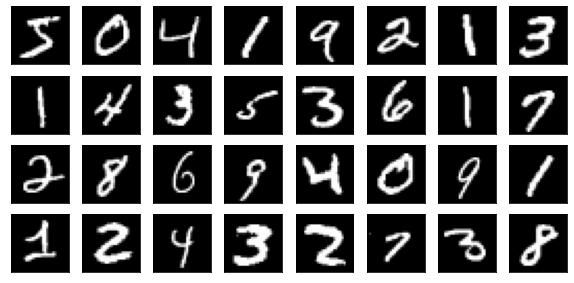

In [ ]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

## Create GAN parts: Generator and Discriminator

In [ ]:
generator = M.Sequential([
    L.Dense(256),
    L.LeakyReLU(0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(512),
    L.LeakyReLU(0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(1024),
    L.LeakyReLU(0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(784, activation='tanh'),
])

discriminator = M.Sequential([
    L.Dense(784, activation=None),
    L.LeakyReLU(alpha=0.2),
    L.Dense(392, activation=None),
    L.LeakyReLU(alpha=0.2),
    L.Dense(1, activation=None),
])

## Training parameters, dataset pipeline, optimizer

In [ ]:
INPUT_DIM = 100
NUM_EPOCHS = 5
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## GAN training

[Step  0] D Loss: 0.9809; G Loss: 0.7640


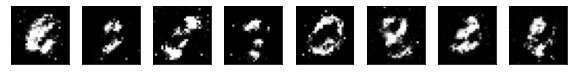

[Step 500] D Loss: 0.6327; G Loss: 0.7882


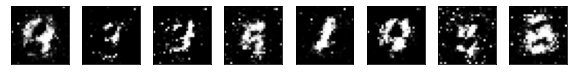

[Step 1000] D Loss: 0.5869; G Loss: 0.8593


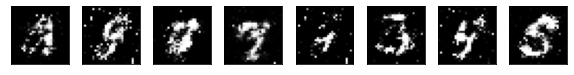

[Step 1500] D Loss: 0.6601; G Loss: 0.9930


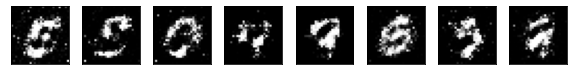

[Step 2000] D Loss: 0.6507; G Loss: 1.0257


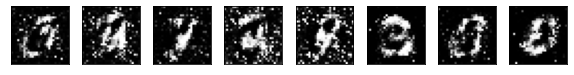

[Step 2500] D Loss: 0.5661; G Loss: 0.9650


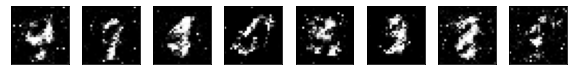

[Step 3000] D Loss: 0.4616; G Loss: 1.7590


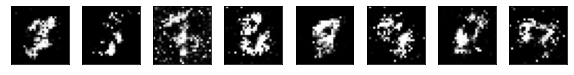

[Step 3500] D Loss: 0.5608; G Loss: 0.9126


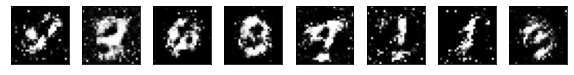

[Step 4000] D Loss: 0.3834; G Loss: 1.4978


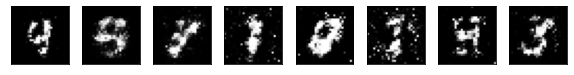

[Step 4500] D Loss: 0.4167; G Loss: 1.1604


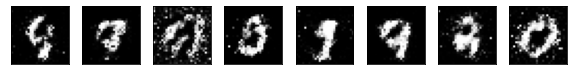

[Step 5000] D Loss: 0.4258; G Loss: 1.5743


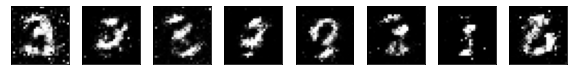

[Step 5500] D Loss: 0.6279; G Loss: 1.0310


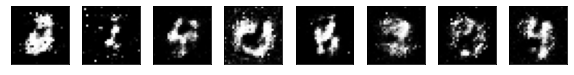

[Step 6000] D Loss: 0.4953; G Loss: 0.9586


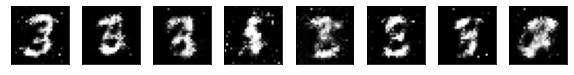

[Step 6500] D Loss: 0.4975; G Loss: 1.3818


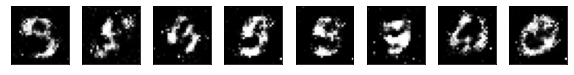

[Step 7000] D Loss: 0.6342; G Loss: 1.3689


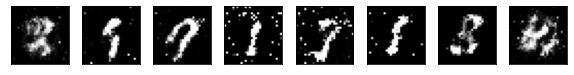

[Step 7500] D Loss: 0.5525; G Loss: 1.3284


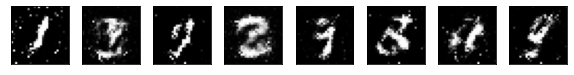

[Step 8000] D Loss: 0.4592; G Loss: 1.9970


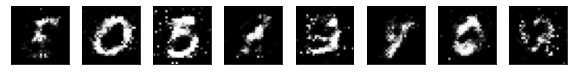

[Step 8500] D Loss: 0.6886; G Loss: 0.5515


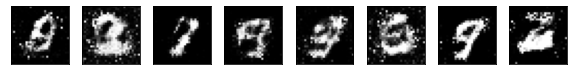

[Step 9000] D Loss: 0.4863; G Loss: 0.6578


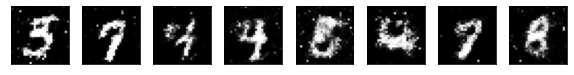

[Step 9500] D Loss: 0.4453; G Loss: 0.7769


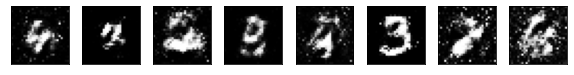

[Step 10000] D Loss: 0.6322; G Loss: 1.0715


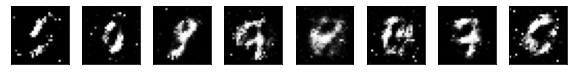

[Step 10500] D Loss: 0.5831; G Loss: 0.7687


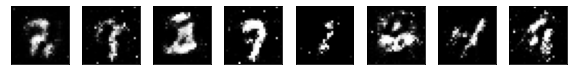

[Step 11000] D Loss: 0.4863; G Loss: 1.4953


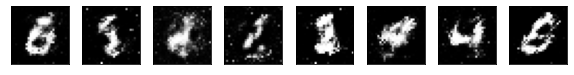

[Step 11500] D Loss: 0.7245; G Loss: 1.3740


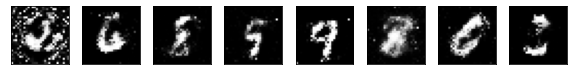

[Step 12000] D Loss: 0.8192; G Loss: 0.9307


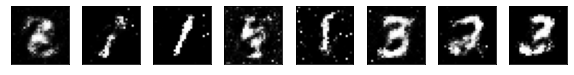

[Step 12500] D Loss: 0.6295; G Loss: 0.9605


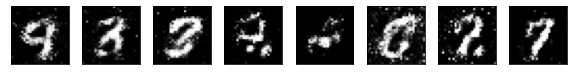

[Step 13000] D Loss: 0.6503; G Loss: 0.8901


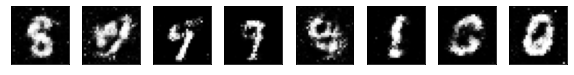

[Step 13500] D Loss: 0.5161; G Loss: 1.1983


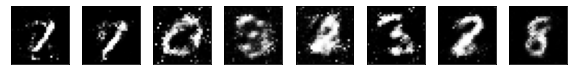

[Step 14000] D Loss: 0.4073; G Loss: 1.1388


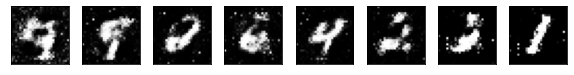

[Step 14500] D Loss: 0.4542; G Loss: 1.4765


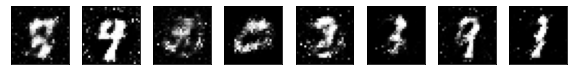

[Step 15000] D Loss: 0.5750; G Loss: 1.5599


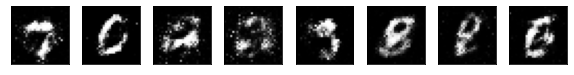

[Step 15500] D Loss: 0.6881; G Loss: 1.1108


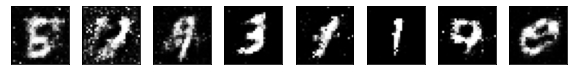

[Step 16000] D Loss: 0.7000; G Loss: 1.5617


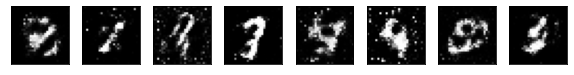

[Step 16500] D Loss: 0.5466; G Loss: 1.2953


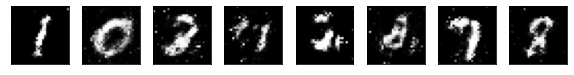

[Step 17000] D Loss: 0.3907; G Loss: 1.4196


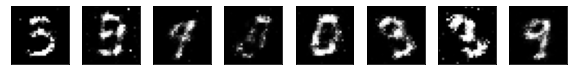

[Step 17500] D Loss: 0.4766; G Loss: 1.3210


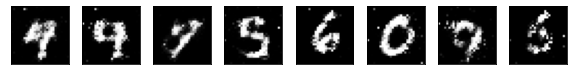

[Step 18000] D Loss: 0.5905; G Loss: 1.1695


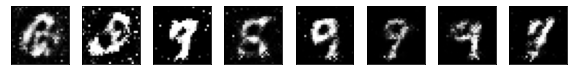

[Step 18500] D Loss: 0.5209; G Loss: 0.9333


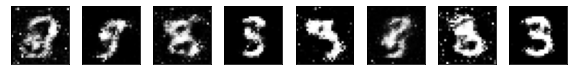

In [ ]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1)), 
        np.zeros((HALF_BATCH_SIZE, 1))))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined)
        d_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1))
    
    with tf.GradientTape() as tape:
        logits = discriminator(generator(noise, training=True))
        g_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print("[Step %2d] D Loss: %.4f; G Loss: %.4f" % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Generator test: random examples

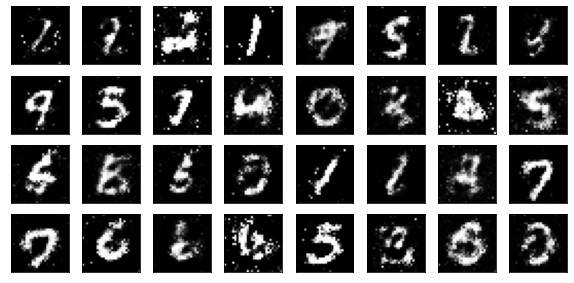

In [ ]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Generator test: continuous examples

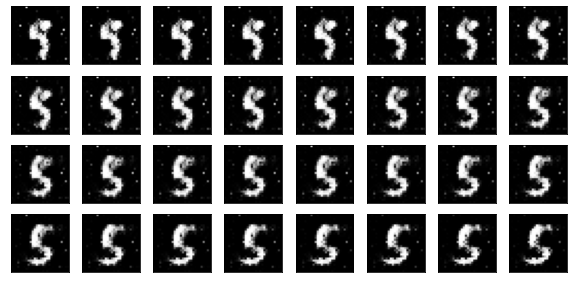

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Deep Convolutional GAN (DCGAN)

In [ ]:
generator = M.Sequential([
    L.Dense(128*7*7, activation="relu"),
    L.Reshape((7, 7, 128)),
    L.UpSampling2D((2, 2)),    
    L.Conv2D(128, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.UpSampling2D((2, 2)),    
    L.Conv2D(64, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.Conv2D(1, (3, 3), padding="same", activation='tanh'),
])

discriminator = M.Sequential([
    L.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    L.LeakyReLU(0.2),
    L.Dropout(0.25),    
    L.Conv2D(64, kernel_size=3, strides=(2, 2), padding="same"),
    L.ZeroPadding2D(padding=((0, 1), (0, 1))),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Conv2D(128, kernel_size=3, strides=(2, 2), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Conv2D(256, kernel_size=3, strides=(1, 1), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Flatten(),
    L.Dense(1, activation=None),
])

## Training parameters, dataset pipeline, optimizer

In [ ]:
INPUT_DIM = 100
NUM_EPOCHS = 2
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x.reshape(-1, 28, 28, 1))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## DCGAN training

[Step  0] D Loss: 0.9829; G Loss: 0.6941


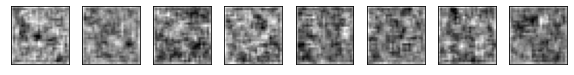

[Step 200] D Loss: 0.6648; G Loss: 1.9468


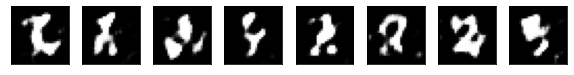

[Step 400] D Loss: 0.5701; G Loss: 1.4681


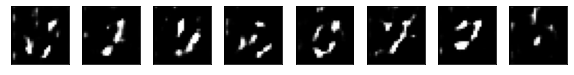

[Step 600] D Loss: 0.6854; G Loss: 1.3124


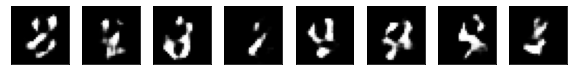

[Step 800] D Loss: 0.7944; G Loss: 0.6402


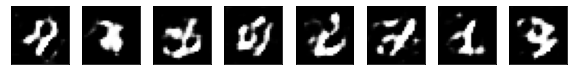

[Step 1000] D Loss: 0.6452; G Loss: 0.8211


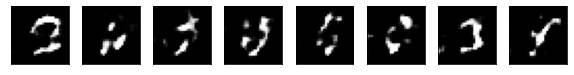

[Step 1200] D Loss: 0.7715; G Loss: 1.0810


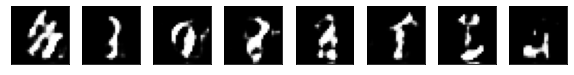

[Step 1400] D Loss: 0.8475; G Loss: 0.6832


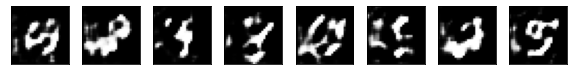

[Step 1600] D Loss: 0.5745; G Loss: 1.1677


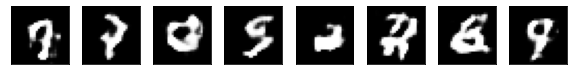

[Step 1800] D Loss: 0.6154; G Loss: 1.0517


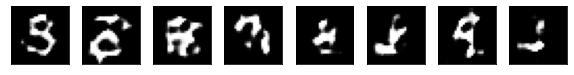

[Step 2000] D Loss: 0.7156; G Loss: 0.9840


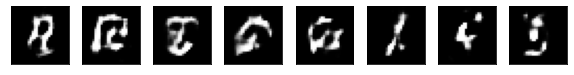

[Step 2200] D Loss: 0.7492; G Loss: 0.7823


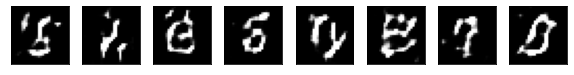

[Step 2400] D Loss: 0.7610; G Loss: 0.8487


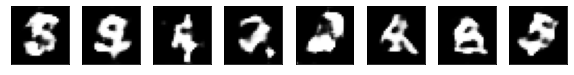

[Step 2600] D Loss: 0.7475; G Loss: 0.7898


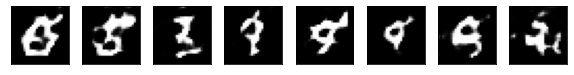

[Step 2800] D Loss: 0.7024; G Loss: 0.9106


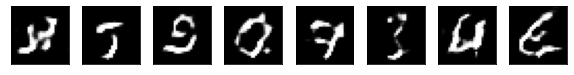

[Step 3000] D Loss: 0.7094; G Loss: 0.8610


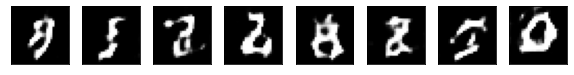

[Step 3200] D Loss: 0.7301; G Loss: 0.9328


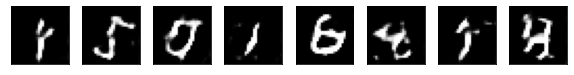

[Step 3400] D Loss: 0.6910; G Loss: 0.8598


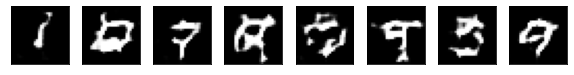

[Step 3600] D Loss: 0.8423; G Loss: 0.8981


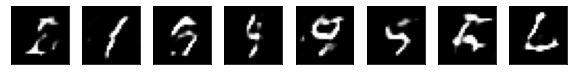

[Step 3800] D Loss: 0.4909; G Loss: 1.0819


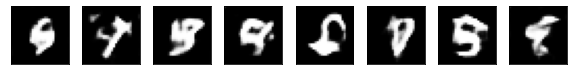

[Step 4000] D Loss: 0.7984; G Loss: 0.7876


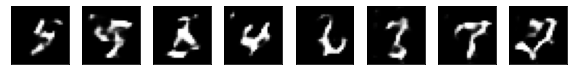

[Step 4200] D Loss: 0.6764; G Loss: 0.8290


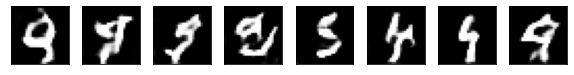

[Step 4400] D Loss: 0.6798; G Loss: 0.9968


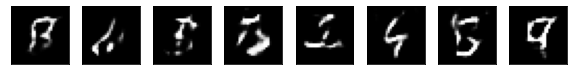

[Step 4600] D Loss: 0.7417; G Loss: 0.5975


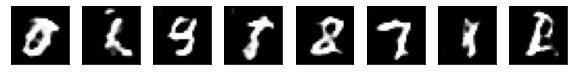

[Step 4800] D Loss: 0.8200; G Loss: 0.5471


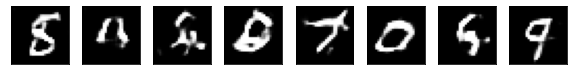

[Step 5000] D Loss: 0.5465; G Loss: 1.0070


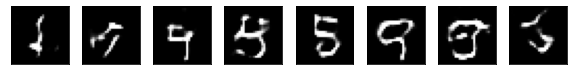

[Step 5200] D Loss: 0.7353; G Loss: 0.8583


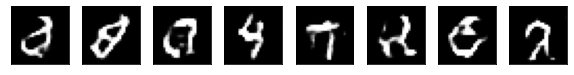

[Step 5400] D Loss: 0.7063; G Loss: 0.7125


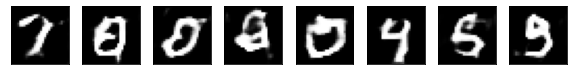

[Step 5600] D Loss: 0.6278; G Loss: 0.8833


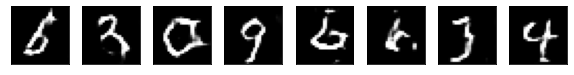

[Step 5800] D Loss: 0.8682; G Loss: 0.8402


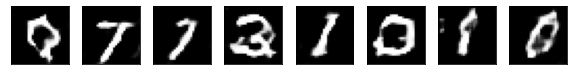

[Step 6000] D Loss: 0.7126; G Loss: 0.9314


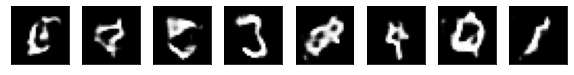

[Step 6200] D Loss: 0.6568; G Loss: 0.8434


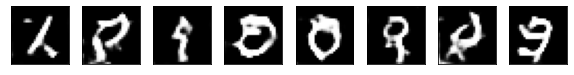

[Step 6400] D Loss: 0.6680; G Loss: 0.7256


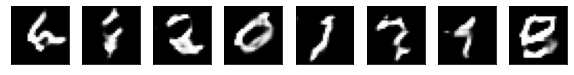

[Step 6600] D Loss: 0.5935; G Loss: 0.9090


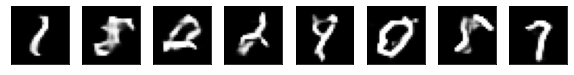

[Step 6800] D Loss: 0.5619; G Loss: 1.0156


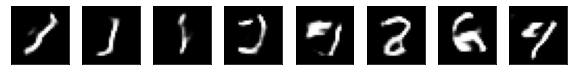

[Step 7000] D Loss: 0.7420; G Loss: 0.7453


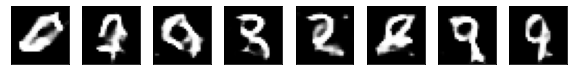

[Step 7200] D Loss: 0.6027; G Loss: 0.7727


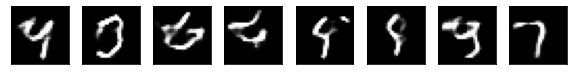

[Step 7400] D Loss: 0.6499; G Loss: 0.7080


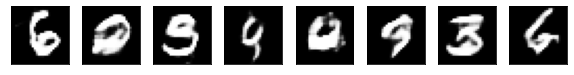

In [ ]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1)), 
        np.zeros((HALF_BATCH_SIZE, 1))))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1))
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print("[Step %2d] D Loss: %.4f; G Loss: %.4f" % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Generator test: random examples

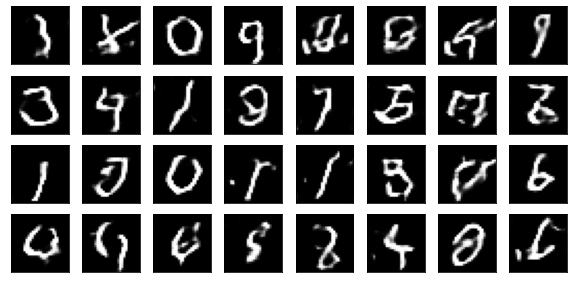

In [ ]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Generator test: continuous examples

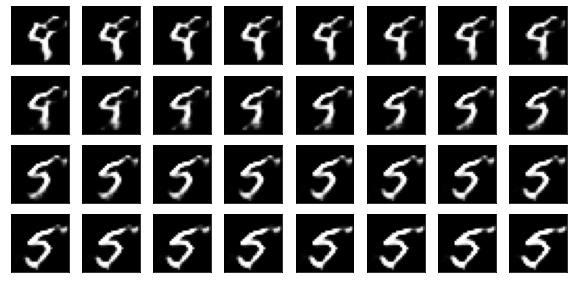

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

In [ ]:
# больше примеров можно найти тут https://github.com/eriklindernoren/Keras-GAN